# Risk Premia Strategy Notebook

This notebook documents the initial data exploration for the Risk Premia Strategy app.

Pull data from local files (originally from BigQuery)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from pathlib import Path

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Load prices from RData file
data_path = Path('..') / 'data' / 'prices.RData'
result = pyreadr.read_r(str(data_path))
prices = result['us_etf_prices']  # Extract the dataframe

# Convert date column to datetime
prices['date'] = pd.to_datetime(prices['date'])

print(f"Loaded {len(prices)} rows of price data")
prices.head()

Loaded 45541 rows of price data


,ticker,date,open,high,low,close,volume,dividends,closeadjusted
0,EMB,1995-01-04,40.221925,40.221925,40.221925,40.221925,0.0,0.0,22.162180
1,GLD,1995-01-04,39.935684,39.935684,39.935684,39.935684,0.0,0.0,39.935684
2,IEF,1995-01-04,43.804373,43.804373,43.804373,43.804373,0.0,0.0,26.182279
3,TLT,1995-01-04,40.786830,40.786830,40.786830,40.786830,0.0,0.0,21.563399
4,VEA,1995-01-04,22.075486,22.075486,22.075486,22.075486,0.0,0.0,15.425231


## Plot Unadjusted Prices

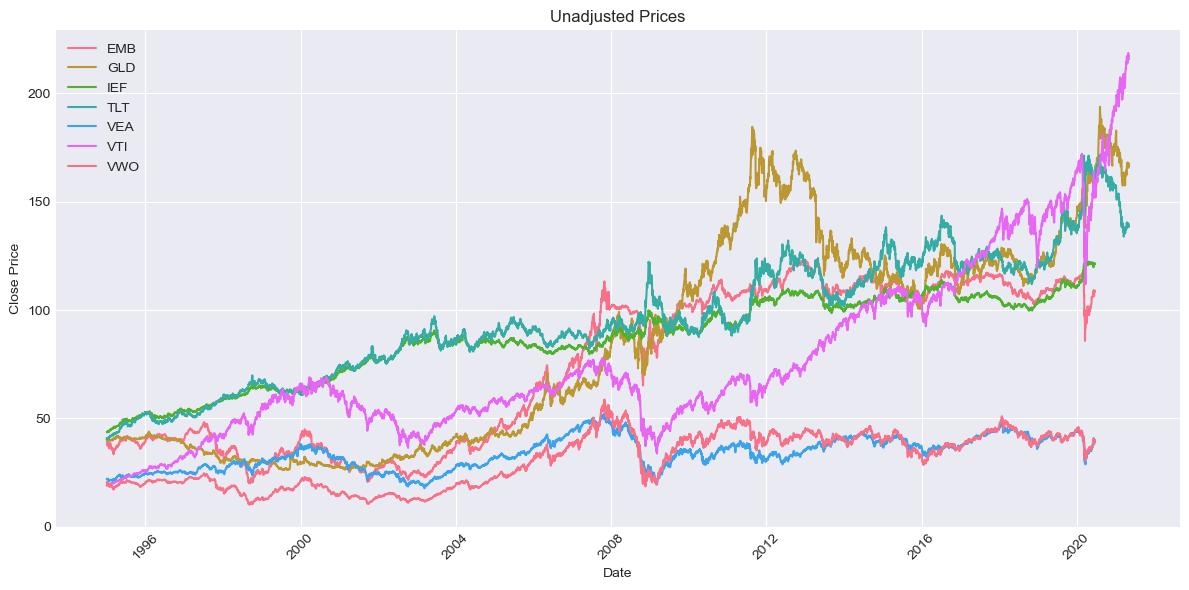

In [2]:
plt.figure(figsize=(12, 6))
for ticker in prices['ticker'].unique():
    ticker_data = prices[prices['ticker'] == ticker]
    plt.plot(ticker_data['date'], ticker_data['close'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Unadjusted Prices')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Calculate Cumulative Returns

Calculate total returns including dividends and create adjusted prices

In [3]:
# Calculate total returns including dividends
totalreturns = prices.copy()
totalreturns = totalreturns.sort_values('date')

# Group by ticker and calculate returns
totalreturns['totalreturns'] = totalreturns.groupby('ticker').apply(
    lambda x: ((x['close'] + x['dividends']) / x['close'].shift(1)) - 1
).reset_index(level=0, drop=True)

# Drop NA values
totalreturns = totalreturns.dropna(subset=['totalreturns'])

# Calculate cumulative returns
totalreturns['cumreturns'] = totalreturns.groupby('ticker')['totalreturns'].apply(
    lambda x: (1 + x).cumprod()
).reset_index(level=0, drop=True)

# Calculate adjustment ratios to get adjusted close prices
adjratios = totalreturns.groupby('ticker').apply(
    lambda x: pd.Series({
        'date': x['date'].max(),
        'close': x.loc[x['date'].idxmax(), 'close'],
        'cumreturns': x.loc[x['date'].idxmax(), 'cumreturns']
    })
).reset_index()

adjratios['ratio'] = adjratios['close'] / adjratios['cumreturns']
adjratios = adjratios[['ticker', 'ratio']]

# Merge and calculate adjusted close
returns = totalreturns.merge(adjratios, on='ticker')
returns['adjclose'] = returns['cumreturns'] * returns['ratio']

print("Calculated returns and adjusted prices")
returns.head()

Calculated returns and adjusted prices


,ticker,date,open,high,low,close,volume,dividends,closeadjusted,totalreturns,cumreturns,ratio,adjclose
0,VWO,1995-01-05,20.682597,20.682597,20.682597,20.682597,0.0,0.0,14.230967,0.008657,1.008657,14.108823,14.230967
1,VWO,1995-01-06,20.337327,20.337327,20.337327,20.337327,0.0,0.0,13.993400,-0.016694,0.991819,14.108823,13.993400
2,VWO,1995-01-09,20.047480,20.047480,20.047480,20.047480,0.0,0.0,13.793966,-0.014252,0.977684,14.108823,13.793966
3,VWO,1995-01-10,19.094274,19.094274,19.094274,19.094274,0.0,0.0,13.138098,-0.047547,0.931197,14.108823,13.138098
4,VWO,1995-01-11,19.308527,19.308527,19.308527,19.308527,0.0,0.0,13.285519,0.011221,0.941646,14.108823,13.285519


## Plot Cumulative Returns

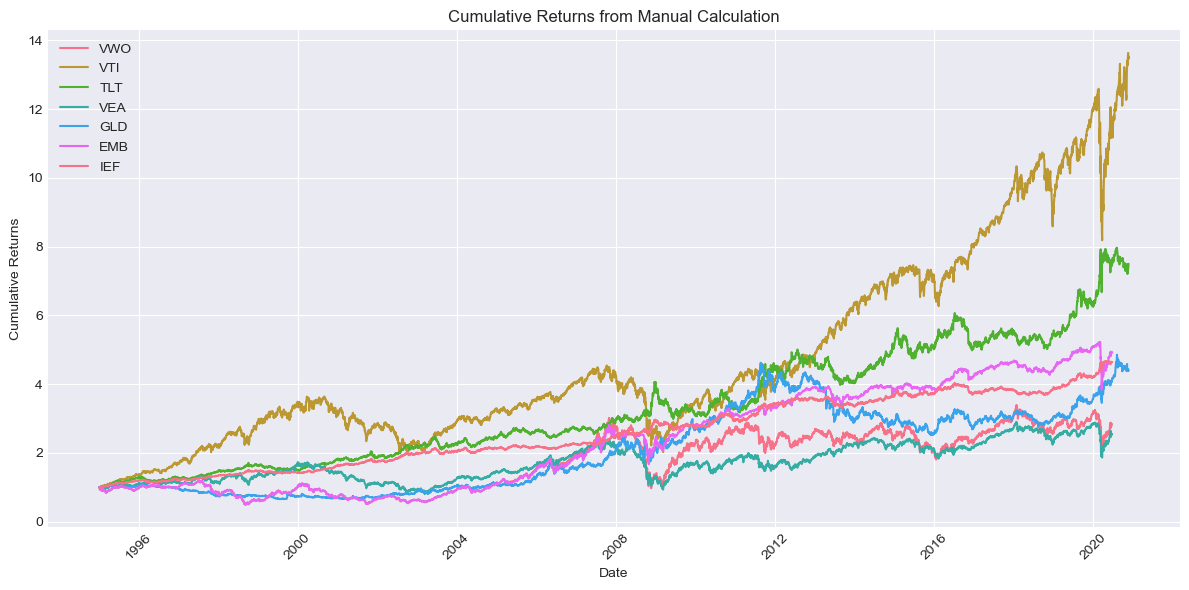

In [4]:
plt.figure(figsize=(12, 6))
for ticker in returns['ticker'].unique():
    ticker_data = returns[returns['ticker'] == ticker]
    plt.plot(ticker_data['date'], ticker_data['cumreturns'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns from Manual Calculation')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Compare with Pre-Adjusted Prices

Compare our calculated returns with the pre-adjusted prices in the dataset

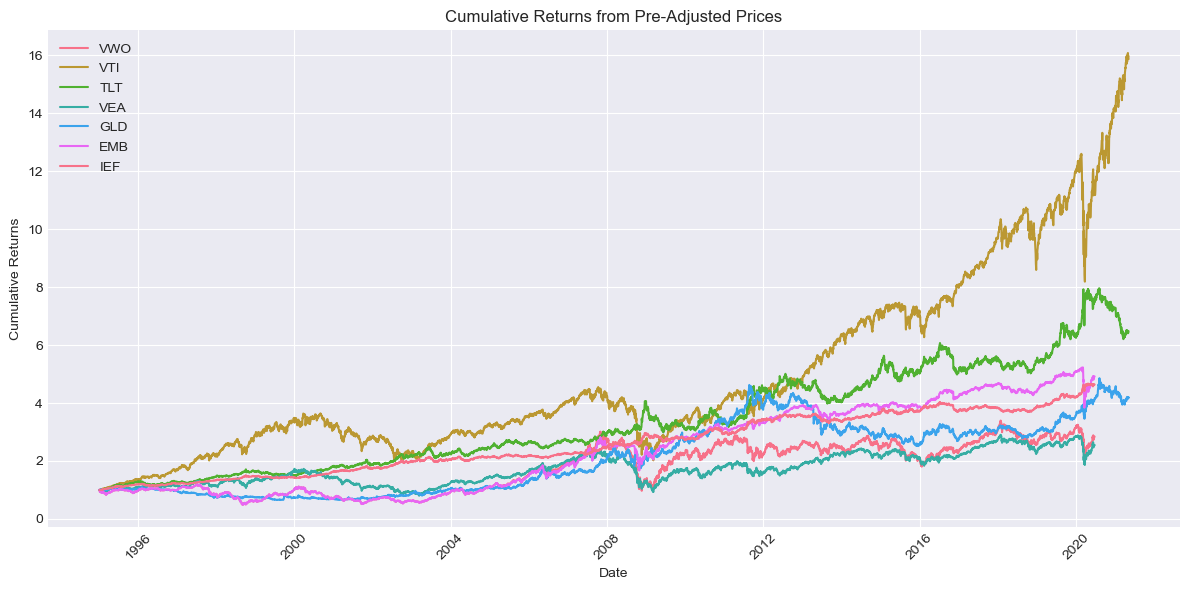

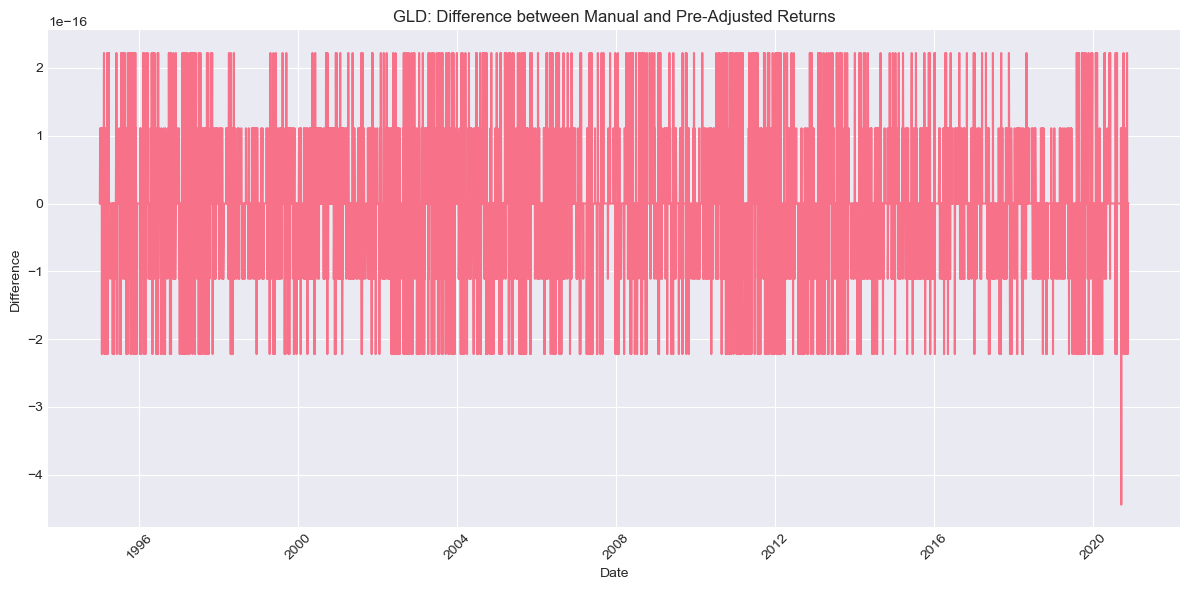

In [5]:
# Calculate returns from closeadjusted column
p = prices.copy()
p = p.sort_values('date')
p['totalreturns'] = p.groupby('ticker')['closeadjusted'].pct_change()
p = p.dropna(subset=['totalreturns'])
p['cumreturns'] = p.groupby('ticker')['totalreturns'].apply(
    lambda x: (1 + x).cumprod()
).reset_index(level=0, drop=True)

# Plot comparison
plt.figure(figsize=(12, 6))
for ticker in p['ticker'].unique():
    ticker_data = p[p['ticker'] == ticker]
    plt.plot(ticker_data['date'], ticker_data['cumreturns'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns from Pre-Adjusted Prices')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot difference for GLD
gld_manual = returns[returns['ticker'] == 'GLD'][['date', 'totalreturns']].rename(columns={'totalreturns': 'manual'})
gld_adjusted = p[p['ticker'] == 'GLD'][['date', 'totalreturns']].rename(columns={'totalreturns': 'adjusted'})
gld_comparison = gld_manual.merge(gld_adjusted, on='date')
gld_comparison['diff'] = gld_comparison['manual'] - gld_comparison['adjusted']

plt.figure(figsize=(12, 6))
plt.plot(gld_comparison['date'], gld_comparison['diff'])
plt.xlabel('Date')
plt.ylabel('Difference')
plt.title('GLD: Difference between Manual and Pre-Adjusted Returns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Validate Adjusted Prices

Check that returns calculated from adjusted prices match total returns

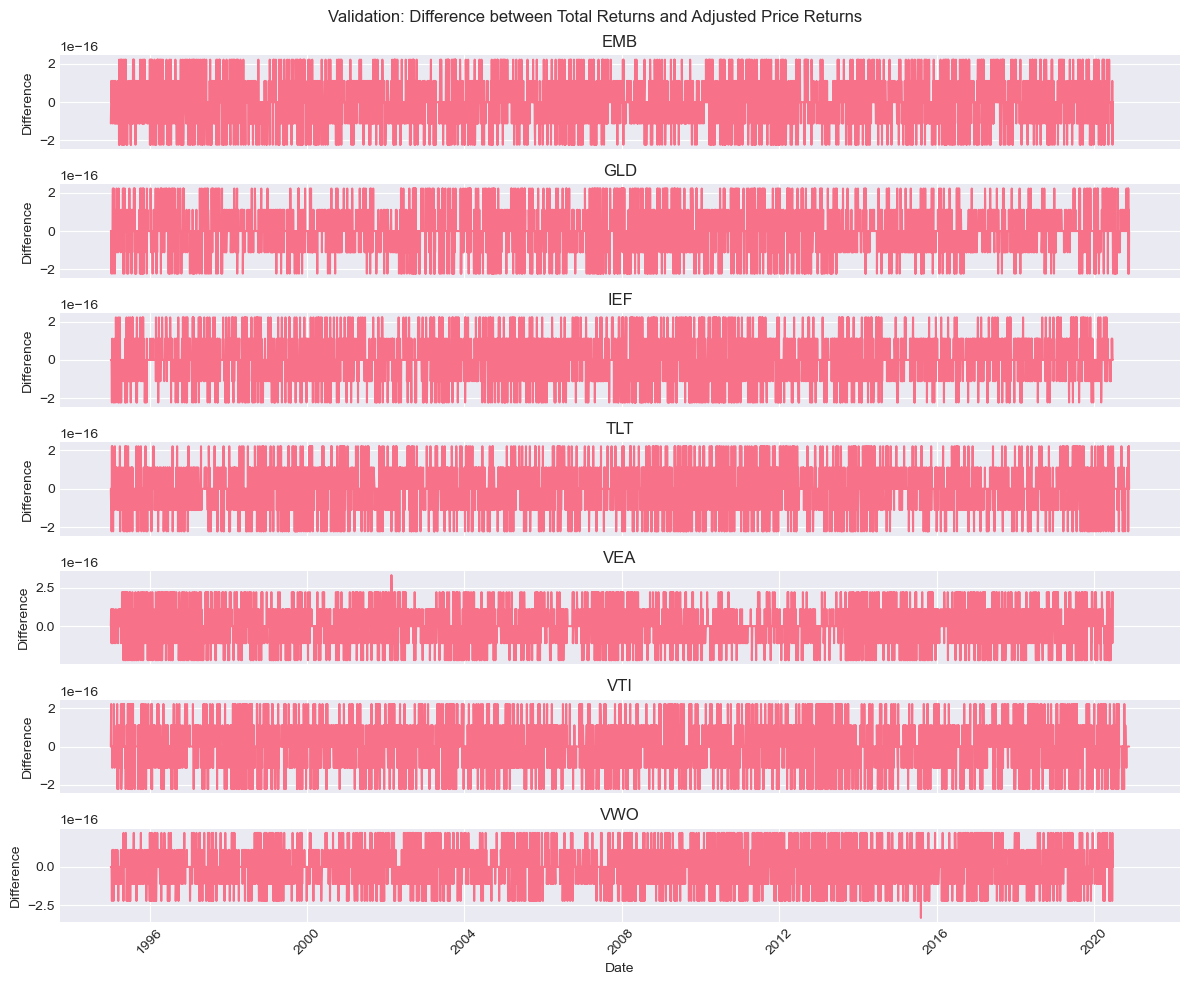

In [6]:
# Calculate returns from our adjusted close
check = returns.copy()
check = check.sort_values(['ticker', 'date'])
check['checkreturns'] = check.groupby('ticker')['adjclose'].pct_change()
check['check'] = check['totalreturns'] - check['checkreturns']
check = check.dropna(subset=['checkreturns'])

# Plot the difference - should be very close to zero
fig, axes = plt.subplots(len(check['ticker'].unique()), 1, figsize=(12, 10), sharex=True)
if len(check['ticker'].unique()) == 1:
    axes = [axes]

for ax, ticker in zip(axes, sorted(check['ticker'].unique())):
    ticker_data = check[check['ticker'] == ticker]
    ax.plot(ticker_data['date'], ticker_data['check'])
    ax.set_ylabel('Difference')
    ax.set_title(ticker)
    ax.tick_params(axis='x', rotation=45)

plt.xlabel('Date')
plt.suptitle('Validation: Difference between Total Returns and Adjusted Price Returns')
plt.tight_layout()
plt.show()

# Equal Weighted Backtest

Filter to the three main ETFs: VTI, GLD, TLT

In [7]:
etfprices = returns[returns['ticker'].isin(['VTI', 'GLD', 'TLT'])].copy()
print(f"Filtered to {len(etfprices)} rows for 3 ETFs")
etfprices.head()

Filtered to 19554 rows for 3 ETFs


,ticker,date,open,high,low,close,volume,dividends,closeadjusted,totalreturns,cumreturns,ratio,adjclose
6411,VTI,1995-01-05,18.953532,18.953532,18.953532,18.953532,0.0,0.0,13.596968,-0.000927,0.999073,13.609578,13.596968
6412,VTI,1995-01-06,18.966763,18.966763,18.966763,18.966763,0.0,0.0,13.606459,0.000698,0.999771,13.609578,13.606459
6413,VTI,1995-01-09,18.975646,18.975646,18.975646,18.975646,0.0,0.0,13.612832,0.000468,1.000239,13.609578,13.612832
6414,VTI,1995-01-10,19.010801,19.010801,19.010801,19.010801,0.0,0.0,13.638052,0.001853,1.002092,13.609578,13.638052
6415,VTI,1995-01-11,19.015149,19.015149,19.015149,19.015149,0.0,0.0,13.641171,0.000229,1.002321,13.609578,13.641171


## Monthly Equal Weight Portfolio

Monthly equal-weight portfolio returns:


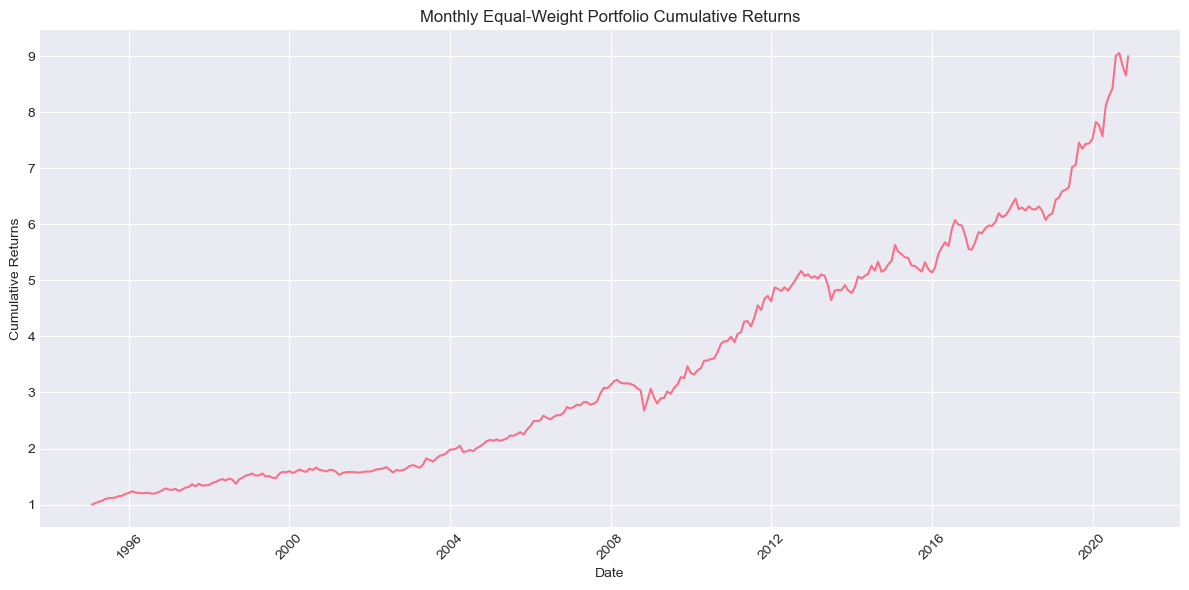


Annualized Return: 9.21%
Annualized Volatility: 8.25%
Sharpe Ratio: 1.12


In [8]:
# Calculate monthly returns for each ETF
etfprices_monthly = etfprices.copy()
etfprices_monthly['year_month'] = etfprices_monthly['date'].dt.to_period('M')

# Get last day of each month
monthly_data = etfprices_monthly.sort_values('date').groupby(['ticker', 'year_month']).last().reset_index()

# Calculate monthly returns
monthly_data = monthly_data.sort_values(['ticker', 'date'])
monthly_data['return'] = monthly_data.groupby('ticker')['adjclose'].pct_change()

# Equal weight portfolio: average of the three returns
monthly_ew = monthly_data.groupby('date')['return'].apply(lambda x: (x * 1/3).sum()).reset_index()
monthly_ew.columns = ['date', 'portfolio']
monthly_ew = monthly_ew.dropna()

print("Monthly equal-weight portfolio returns:")
monthly_ew.head()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(monthly_ew['date'], (1 + monthly_ew['portfolio']).cumprod())
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Monthly Equal-Weight Portfolio Cumulative Returns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate annualized performance metrics
monthly_returns = monthly_ew['portfolio'].dropna()
annual_return = (1 + monthly_returns.mean())**12 - 1
annual_vol = monthly_returns.std() * np.sqrt(12)
sharpe = annual_return / annual_vol

print(f"\nAnnualized Return: {annual_return:.2%}")
print(f"Annualized Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

## Daily Equal Weight Portfolio

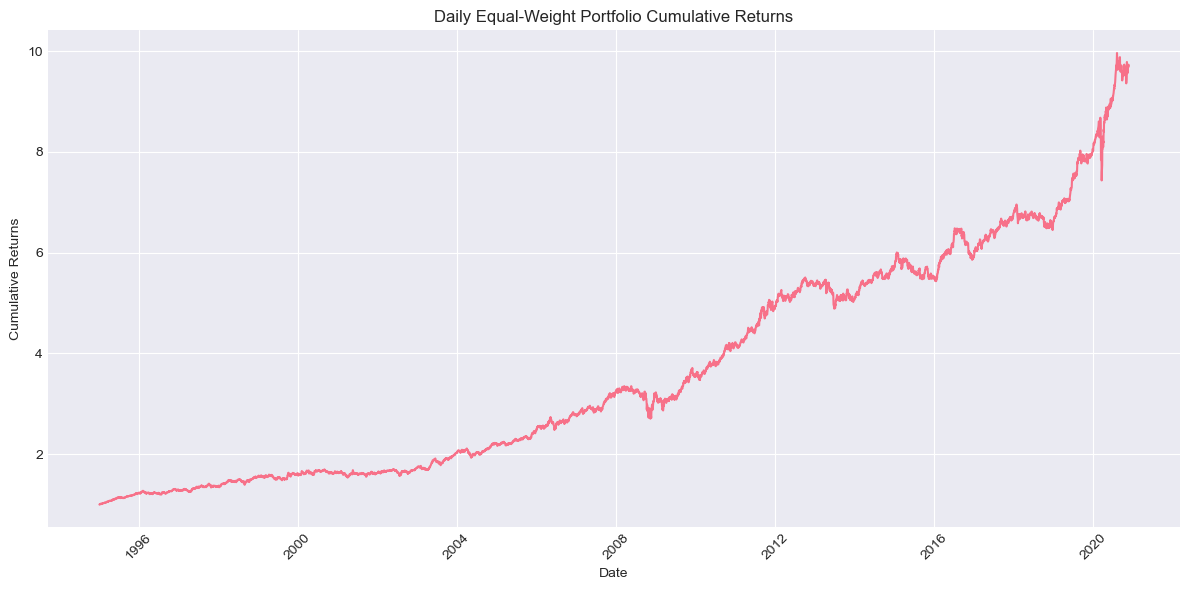

Full Period:
Annualized Return: 9.62%
Annualized Volatility: 8.79%
Sharpe Ratio: 1.09

From 2010-01-01:
Annualized Return: 10.16%
Annualized Volatility: 8.49%
Sharpe Ratio: 1.20


In [9]:
# Daily equal weight: average daily returns
daily_ew = etfprices.groupby('date')['totalreturns'].mean().reset_index()
daily_ew.columns = ['date', 'portfolio']

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(daily_ew['date'], (1 + daily_ew['portfolio']).cumprod())
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Daily Equal-Weight Portfolio Cumulative Returns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Full period performance
daily_returns = daily_ew['portfolio'].dropna()
annual_return = (1 + daily_returns.mean())**252 - 1
annual_vol = daily_returns.std() * np.sqrt(252)
sharpe = annual_return / annual_vol

print(f"Full Period:")
print(f"Annualized Return: {annual_return:.2%}")
print(f"Annualized Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

# Performance from 2010 onwards
daily_ew_2010 = daily_ew[daily_ew['date'] >= '2010-01-01'].copy()
daily_returns_2010 = daily_ew_2010['portfolio'].dropna()
annual_return_2010 = (1 + daily_returns_2010.mean())**252 - 1
annual_vol_2010 = daily_returns_2010.std() * np.sqrt(252)
sharpe_2010 = annual_return_2010 / annual_vol_2010

print(f"\nFrom 2010-01-01:")
print(f"Annualized Return: {annual_return_2010:.2%}")
print(f"Annualized Volatility: {annual_vol_2010:.2%}")
print(f"Sharpe Ratio: {sharpe_2010:.2f}")

# Volatility Targeting on Individual Assets

Size each asset to a target volatility (5% annualized) using a rolling 60-day volatility estimate

In [10]:
vol_target = 0.05  # 5% annualized volatility target

# Calculate rolling volatility and position sizing
volsize = etfprices.copy()
volsize = volsize.sort_values(['ticker', 'date'])

# Calculate 60-day rolling volatility (annualized)
volsize['vol20'] = volsize.groupby('ticker')['totalreturns'].transform(
    lambda x: x.rolling(window=60, min_periods=60).std() * np.sqrt(252)
)

# Position size based on volatility target (lagged by 1 day)
volsize['vol20size'] = (vol_target / volsize['vol20']).shift(1)
volsize['vol20returns'] = volsize['vol20size'] * volsize['totalreturns']
volsize = volsize.dropna()

print(f"Calculated volatility-based position sizing")
volsize.head()

Calculated volatility-based position sizing


,ticker,date,open,high,low,close,volume,dividends,closeadjusted,totalreturns,cumreturns,ratio,adjclose,vol20,vol20size,vol20returns
25918,GLD,1995-03-31,41.619927,41.619927,41.619927,41.619927,0.0,0.0,41.619927,0.022404,1.042174,39.935684,41.619927,0.082558,0.723323,0.016205
25919,GLD,1995-04-03,41.650898,41.650898,41.650898,41.650898,0.0,0.0,41.650898,0.000744,1.042949,39.935684,41.650898,0.082531,0.605638,0.000451
25920,GLD,1995-04-04,41.586104,41.586104,41.586104,41.586104,0.0,0.0,41.586104,-0.001556,1.041327,39.935684,41.586104,0.080890,0.605836,-0.000942
25921,GLD,1995-04-05,41.622372,41.622372,41.622372,41.622372,0.0,0.0,41.622372,0.000872,1.042235,39.935684,41.622372,0.080521,0.618122,0.000539
25922,GLD,1995-04-06,41.764594,41.764594,41.764594,41.764594,0.0,0.0,41.764594,0.003417,1.045796,39.935684,41.764594,0.080432,0.620959,0.002122


## Daily Rebalance with Volatility Targeting

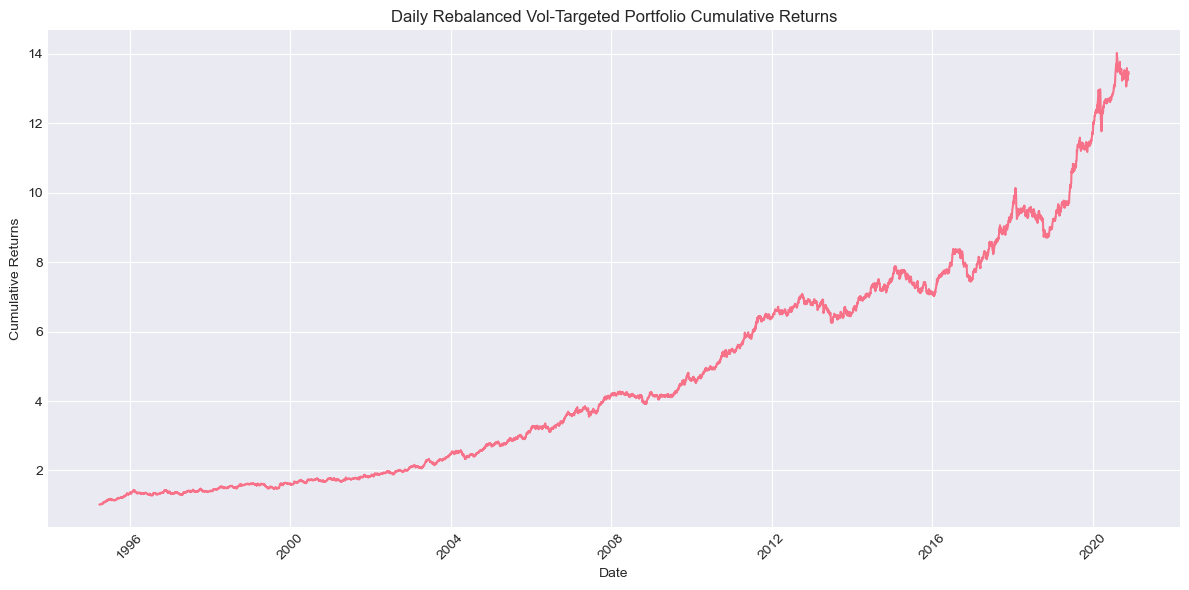

Full Period:
Annualized Return: 11.12%
Annualized Volatility: 8.87%
Sharpe Ratio: 1.25

From 2010-01-01:
Annualized Return: 10.83%
Annualized Volatility: 8.56%
Sharpe Ratio: 1.27


In [11]:
# Sum across assets for each day
volsizeportfolio = volsize.groupby('date')['vol20returns'].sum().reset_index()
volsizeportfolio.columns = ['date', 'portfolio']

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(volsizeportfolio['date'], (1 + volsizeportfolio['portfolio']).cumprod())
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Daily Rebalanced Vol-Targeted Portfolio Cumulative Returns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Performance metrics
vol_returns = volsizeportfolio['portfolio'].dropna()
annual_return = (1 + vol_returns.mean())**252 - 1
annual_vol = vol_returns.std() * np.sqrt(252)
sharpe = annual_return / annual_vol

print(f"Full Period:")
print(f"Annualized Return: {annual_return:.2%}")
print(f"Annualized Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

# From 2010
volsizeportfolio_2010 = volsizeportfolio[volsizeportfolio['date'] >= '2010-01-01'].copy()
vol_returns_2010 = volsizeportfolio_2010['portfolio'].dropna()
annual_return_2010 = (1 + vol_returns_2010.mean())**252 - 1
annual_vol_2010 = vol_returns_2010.std() * np.sqrt(252)
sharpe_2010 = annual_return_2010 / annual_vol_2010

print(f"\nFrom 2010-01-01:")
print(f"Annualized Return: {annual_return_2010:.2%}")
print(f"Annualized Volatility: {annual_vol_2010:.2%}")
print(f"Sharpe Ratio: {sharpe_2010:.2f}")

## Monthly Rebalance with Volatility Targeting

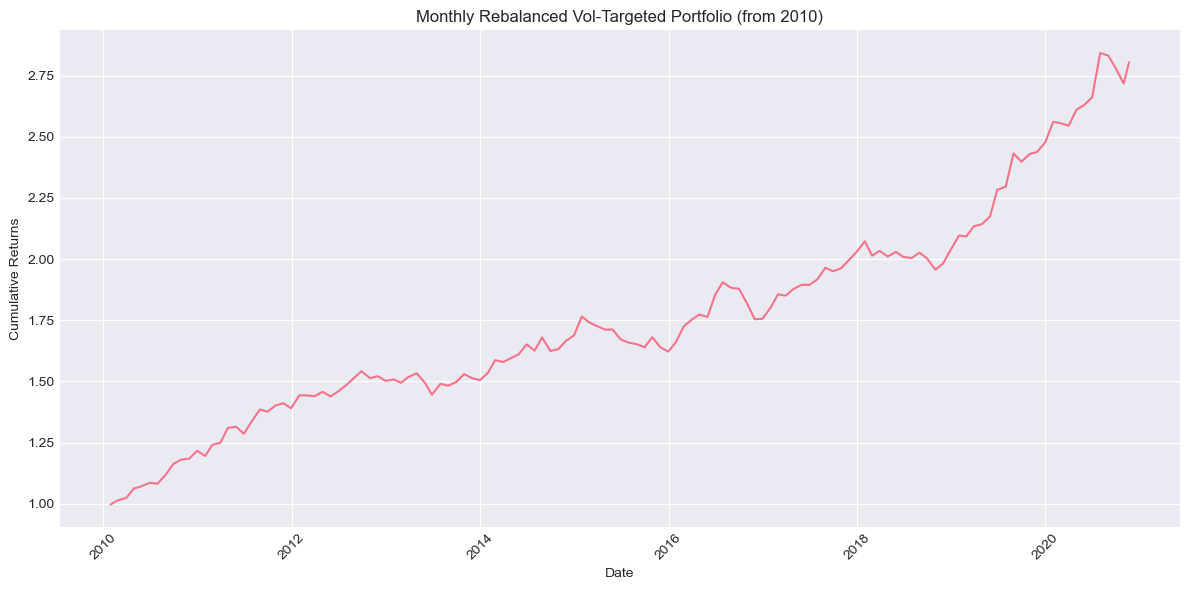

Full Period:
Annualized Return: 9.28%
Annualized Volatility: 6.74%
Sharpe Ratio: 1.38

From 2010-01-01:
Annualized Return: 10.18%
Annualized Volatility: 7.09%
Sharpe Ratio: 1.44


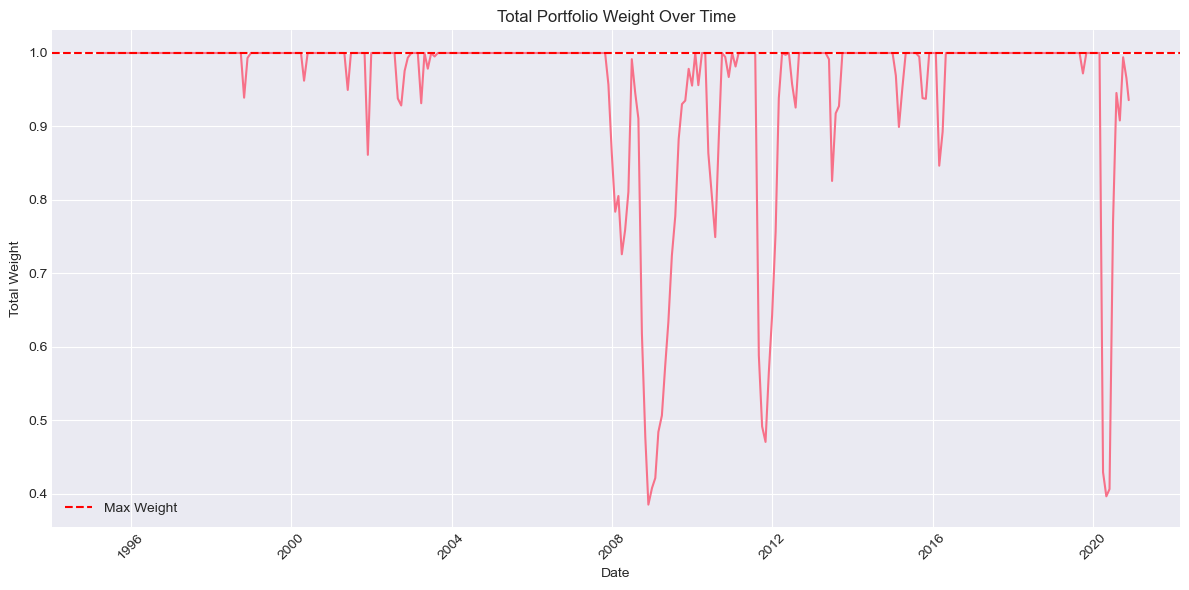

In [12]:
# Get monthly returns for each ticker
volsize_monthly = volsize.copy()
volsize_monthly['year_month'] = volsize_monthly['date'].dt.to_period('M')

# Get last day of each month with vol sizing
monthreturns = volsize_monthly.sort_values('date').groupby(['ticker', 'year_month']).last().reset_index()

# Calculate monthly returns
monthreturns = monthreturns.sort_values(['ticker', 'date'])
monthreturns['return'] = monthreturns.groupby('ticker')['adjclose'].pct_change()
monthreturns = monthreturns[['ticker', 'date', 'vol20size', 'return']].dropna()

# Calculate adjustment factors to constrain total weight to 1
adjustmentfactors = monthreturns.groupby('date')['vol20size'].sum().reset_index()
adjustmentfactors.columns = ['date', 'totalweight']
adjustmentfactors['adjfactor'] = np.where(
    adjustmentfactors['totalweight'] > 1,
    1 / adjustmentfactors['totalweight'],
    1
)

# Apply adjustment factors
monthstrategyreturns = monthreturns.merge(adjustmentfactors, on='date')
monthstrategyreturns['constrainedsize'] = monthstrategyreturns['vol20size'] * monthstrategyreturns['adjfactor']
monthstrategyreturns['weightedreturn'] = monthstrategyreturns['constrainedsize'] * monthstrategyreturns['return']

# Sum to get portfolio returns
month_rebal = monthstrategyreturns.groupby('date')['weightedreturn'].sum().reset_index()
month_rebal.columns = ['date', 'portfolio']

# Plot from 2010
month_rebal_2010 = month_rebal[month_rebal['date'] >= '2010-01-01'].copy()
plt.figure(figsize=(12, 6))
plt.plot(month_rebal_2010['date'], (1 + month_rebal_2010['portfolio']).cumprod())
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Monthly Rebalanced Vol-Targeted Portfolio (from 2010)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Performance metrics - full period
month_returns = month_rebal['portfolio'].dropna()
annual_return = (1 + month_returns.mean())**12 - 1
annual_vol = month_returns.std() * np.sqrt(12)
sharpe = annual_return / annual_vol

print(f"Full Period:")
print(f"Annualized Return: {annual_return:.2%}")
print(f"Annualized Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

# From 2010
month_returns_2010 = month_rebal_2010['portfolio'].dropna()
annual_return_2010 = (1 + month_returns_2010.mean())**12 - 1
annual_vol_2010 = month_returns_2010.std() * np.sqrt(12)
sharpe_2010 = annual_return_2010 / annual_vol_2010

print(f"\nFrom 2010-01-01:")
print(f"Annualized Return: {annual_return_2010:.2%}")
print(f"Annualized Volatility: {annual_vol_2010:.2%}")
print(f"Sharpe Ratio: {sharpe_2010:.2f}")

# Plot total weight over time
totalweights = monthstrategyreturns.groupby('date')['constrainedsize'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(totalweights['date'], totalweights['constrainedsize'])
plt.xlabel('Date')
plt.ylabel('Total Weight')
plt.title('Total Portfolio Weight Over Time')
plt.axhline(y=1, color='r', linestyle='--', label='Max Weight')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Export Portfolio Returns

Save the monthly rebalanced portfolio returns from 2010 onwards

In [13]:
import pickle

# Prepare data for export
dump = month_rebal[month_rebal['date'] >= '2010-01-01'].copy()
dump['date'] = dump['date'].dt.to_period('M').dt.to_timestamp()

# Save as pickle (Python equivalent of RDS)
output_path = Path('..') / 'data' / 'rp-returns-7vol.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(dump, f)

print(f"Saved portfolio returns to {output_path}")
dump.head()

Saved portfolio returns to ..\data\rp-returns-7vol.pkl


,date,portfolio
177,2010-01-01,-0.003103
178,2010-02-01,0.017288
179,2010-03-01,0.009779
180,2010-04-01,0.037677
181,2010-05-01,0.007968


# Scatterplot Analysis

## Monthly Returns vs Past Month Returns

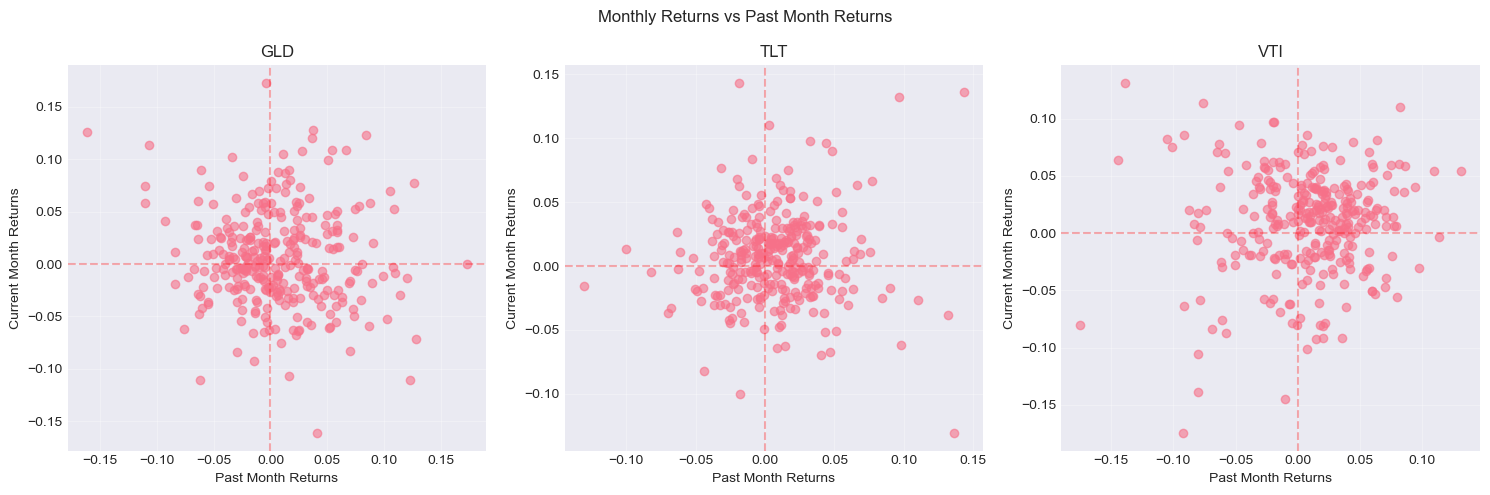

In [14]:
# Add lagged returns
scatter_data = monthreturns.copy()
scatter_data['pastreturns'] = scatter_data.groupby('ticker')['return'].shift(1)
scatter_data = scatter_data.dropna()

# Create faceted scatterplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, ticker in zip(axes, sorted(scatter_data['ticker'].unique())):
    ticker_data = scatter_data[scatter_data['ticker'] == ticker]
    ax.scatter(ticker_data['pastreturns'], ticker_data['return'], alpha=0.6)
    ax.set_xlabel('Past Month Returns')
    ax.set_ylabel('Current Month Returns')
    ax.set_title(ticker)
    ax.grid(True, alpha=0.3)
    
    # Add a reference line at y=0 and x=0
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='r', linestyle='--', alpha=0.3)

plt.suptitle('Monthly Returns vs Past Month Returns')
plt.tight_layout()
plt.show()

## Volatility vs Past Month Volatility

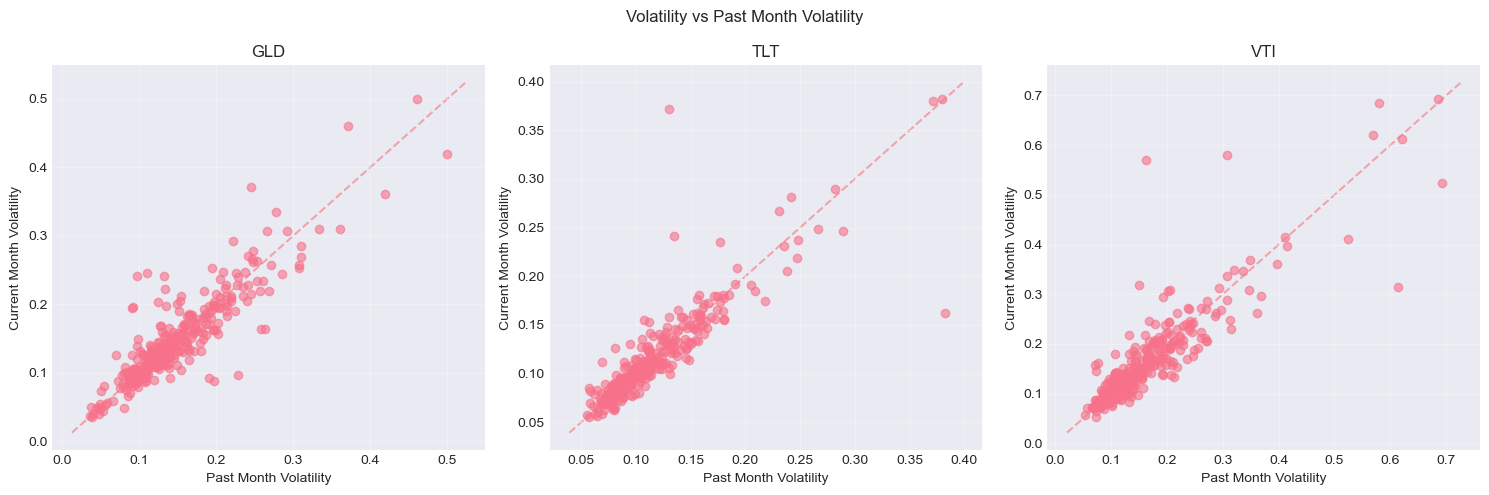

In [15]:
# Calculate volatility from vol size
vol_scatter = monthreturns.copy()
vol_scatter['vol20'] = vol_target / vol_scatter['vol20size']
vol_scatter['pastvol20'] = vol_scatter.groupby('ticker')['vol20'].shift(1)
vol_scatter = vol_scatter.dropna()

# Create faceted scatterplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, ticker in zip(axes, sorted(vol_scatter['ticker'].unique())):
    ticker_data = vol_scatter[vol_scatter['ticker'] == ticker]
    ax.scatter(ticker_data['pastvol20'], ticker_data['vol20'], alpha=0.6)
    ax.set_xlabel('Past Month Volatility')
    ax.set_ylabel('Current Month Volatility')
    ax.set_title(ticker)
    ax.grid(True, alpha=0.3)
    
    # Add diagonal line for reference
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.3, zorder=0)

plt.suptitle('Volatility vs Past Month Volatility')
plt.tight_layout()
plt.show()